In [1]:
import os
import sys

path_root = os.path.dirname(os.getcwd())

if path_root not in sys.path:
    sys.path.append(path_root)

In [2]:
from src.config import path_output_synthea, path_output_llm, path_output_extraction, path_output_standardisation
from src.generate.synthea import GenerateSynthea
from src.generate.llm import GenerateLLM
from src.extraction.extraction import Extraction
from src.standardise_extraction.standardise_extraction import StandardiseExtraction
from src.privacy_risk_scorer.privacy_risk_scorer import PrivacyRiskScorer
from src.privacy_risk_explainer.privacy_risk_explainer import PrivacyRiskExplainer
from src import config

# Privacy Fingerprint End-to-End Overview

The Pipeline has been broken down into four components:
1. **GenerateSynthea**: This generates a list of dictionary of synthetic patient records.
2. **GenerateLLM**: This generates medical notes using the outputs created from **GenerateSynthea**.
3. **Extraction**: This currently uses an LLM that is specialised to extract given entities from the synthetic medical notes produced by **GenerativeLLM**
4. **StandardiseExtraction**: This standardises the results extracted from the medical text.

Each of these classes takes in a path_output, when save_output is set to True, it will save the output to this path_output defined.
These paths have been defined in the src/config.py file:
- path_output_synthea = data_folder + "/synthea.json"
- path_output_llm = data_folder + "/llm.json"
- path_output_extraction = data_folder + "/generative.json"
- path_output_standardisation = data_folder + "/standardisation.json"

Additionally each class will also take a path for the input required to create their output. This allows the user to break-up the pipeline and run from specific points in the pipeline.

## 1. GenerateSynthea: Generating Synthetic Patient Data using Synthea 

Synthea-international is an expansion of Synthea, which is an open-source synthetic patient generator that produces de-identified health records for synthetic patients.

GenerateSynthea is a class used to run Synthea. You will need to follow the instructions on the README to ensure Synthea is installed.
- "./run_synthea" is a command line input that calls to run synthea.
- "-p" is a person flag
- "5" Where 5 determines the number of patients you want to generate. (Alter this to generate more records.)
- "West Yorkshire" Synthea only works on a regional basis, therefore you have to give county information so it can generate address type data.

In the src/config.py there is some given config values:
- path_synthea = "../../synthea" - This defines the location of where synthea is from the src folder.
- path_csv = path_synthea + "/output/csv" - This defines the location where outputs are saved to when synthea is ran.
- path_patients = path_csv + "/patients.csv" - This is a .csv that holds patients synthetic demographic information etc. 
- path_encounters = path_csv + "/encounters.csv" - This is a .csv that holds encounters, i.e., this holds multiple times a patient has gone for medical assessment/treatment.
- cols_patients = ["Id", "BIRTHDATE", "FIRST", "LAST"] - This determines the columns we extract from path_patients.
- cols_encounters = ["PATIENT", "ENCOUNTERCLASS", "REASONDESCRIPTION"] - This defines the columns we extract from path_encounters.

In [3]:
output_synthea = GenerateSynthea(path_output=path_output_synthea, save_output=True).run("./run_synthea", "-p", "10", "West Yorkshire")
output_synthea

[{'NHS_NUMBER': '3020263689',
  'DATE_OF_BIRTH': '2024-01-28',
  'GIVEN_NAME': 'Lela',
  'FAMILY_NAME': 'Koch',
  'DIAGNOSIS': nan},
 {'NHS_NUMBER': '0559310749',
  'DATE_OF_BIRTH': '2018-03-02',
  'GIVEN_NAME': 'Chaya',
  'FAMILY_NAME': 'Bashirian',
  'DIAGNOSIS': 'Acute bronchitis (disorder)'},
 {'NHS_NUMBER': '6773309492',
  'DATE_OF_BIRTH': '2015-09-02',
  'GIVEN_NAME': 'Maryln',
  'FAMILY_NAME': 'Reichel',
  'DIAGNOSIS': 'Otitis media'},
 {'NHS_NUMBER': '8325913282',
  'DATE_OF_BIRTH': '2013-04-29',
  'GIVEN_NAME': 'Marni',
  'FAMILY_NAME': 'Shields',
  'DIAGNOSIS': 'Viral sinusitis (disorder)'},
 {'NHS_NUMBER': '6253357409',
  'DATE_OF_BIRTH': '2011-09-13',
  'GIVEN_NAME': 'Lauren',
  'FAMILY_NAME': 'Hoeger',
  'DIAGNOSIS': 'Childhood asthma'},
 {'NHS_NUMBER': '7930195430',
  'DATE_OF_BIRTH': '2010-03-09',
  'GIVEN_NAME': 'Cyril',
  'FAMILY_NAME': 'Haag',
  'DIAGNOSIS': 'Sinusitis (disorder)'},
 {'NHS_NUMBER': '0472538039',
  'DATE_OF_BIRTH': '2006-05-11',
  'GIVEN_NAME': 'Devora

This loads the model from path

In [4]:
output_synthea = GenerateSynthea(path_output=path_output_synthea).load()
output_synthea

[{'NHS_NUMBER': '3020263689',
  'DATE_OF_BIRTH': '2024-01-28',
  'GIVEN_NAME': 'Lela',
  'FAMILY_NAME': 'Koch',
  'DIAGNOSIS': nan},
 {'NHS_NUMBER': '0559310749',
  'DATE_OF_BIRTH': '2018-03-02',
  'GIVEN_NAME': 'Chaya',
  'FAMILY_NAME': 'Bashirian',
  'DIAGNOSIS': 'Acute bronchitis (disorder)'},
 {'NHS_NUMBER': '6773309492',
  'DATE_OF_BIRTH': '2015-09-02',
  'GIVEN_NAME': 'Maryln',
  'FAMILY_NAME': 'Reichel',
  'DIAGNOSIS': 'Otitis media'},
 {'NHS_NUMBER': '8325913282',
  'DATE_OF_BIRTH': '2013-04-29',
  'GIVEN_NAME': 'Marni',
  'FAMILY_NAME': 'Shields',
  'DIAGNOSIS': 'Viral sinusitis (disorder)'},
 {'NHS_NUMBER': '6253357409',
  'DATE_OF_BIRTH': '2011-09-13',
  'GIVEN_NAME': 'Lauren',
  'FAMILY_NAME': 'Hoeger',
  'DIAGNOSIS': 'Childhood asthma'},
 {'NHS_NUMBER': '7930195430',
  'DATE_OF_BIRTH': '2010-03-09',
  'GIVEN_NAME': 'Cyril',
  'FAMILY_NAME': 'Haag',
  'DIAGNOSIS': 'Sinusitis (disorder)'},
 {'NHS_NUMBER': '0472538039',
  'DATE_OF_BIRTH': '2006-05-11',
  'GIVEN_NAME': 'Devora

## 2. GenerateLLM: Generating Synthetic Patient Medical Notes 

Currenty GenerateLLM uses Ollama to run a range of pre-trained models you can use.
- model - This determines the model you want to use.
- template - This defines the prompt-template you want to give to the LLM model to generate each patients medical record.

In the src/config.py file, there is a *cols* parameter. This parameter currently maps Synthea column names to names used in the template to generate these medical notes.

```
cols = {
    "NHS_NUMBER": "NHS_NUMBER",
    "BIRTHDATE": "DATE_OF_BIRTH",
    "FIRST": "GIVEN_NAME",
    "LAST": "FAMILY_NAME",
    "REASONDESCRIPTION": "DIAGNOSIS",
}
```

In [5]:
model = "llama2"
template = """[INST]
<<SYS>>
You are a medical student answering an exam question about writing clinical notes for patients.
<</SYS>>

Keep in mind that your answer will be asssessed based on incorporating all the provided information and the quality of prose.

1. Use prose to write an example clinical note for this patient's doctor.
2. Use less than three sentences.
3. Do not provide a recommendations.
4. Use the following information:

{data}
[/INST]
"""

This runs GenerateLLM using the synthea output from the previous run, and saves the LLM output to the given path_output_llm.

In [6]:
output_llm =  GenerateLLM(synthea_input=output_synthea, path_output=path_output_llm, save_output=True).run(model, template)
output_llm

Clinical Note:
Patient Name: Lela Koch
NHS Number: 3020263689
Date of Birth: January 28, 2024

Presentation: The patient, Lela Koch, a 17-year-old female, presented to the clinic today with complaints of persistent headaches and blurred vision. She reported that these symptoms have been present for the past week and have worsened over time. No other symptoms were reported.Clinical Note:
Patient: Chaya Bashirian
NHS Number: 0559310749
Date of Birth: March 2, 2018

Chaya Bashirian, a 25-year-old female patient, presents with symptoms of acute bronchitis. She reports coughing and wheezing for the past week, along with chest tightness and shortness of breath. Her date of birth is March 2, 2018. Based on her symptoms and medical history, I suspect she may have an upper respiratory infection. Further evaluation and diagnosis are necessary to confirm the diagnosis and develop an appropriate treatment plan. Clinical Note:
Patient Name: Maryln Reichel
NHS Number: 6773309492
Date of Birth: Septe

['Clinical Note:\nPatient Name: Lela Koch\nNHS Number: 3020263689\nDate of Birth: January 28, 2024\n\nPresentation: The patient, Lela Koch, a 17-year-old female, presented to the clinic today with complaints of persistent headaches and blurred vision. She reported that these symptoms have been present for the past week and have worsened over time. No other symptoms were reported.',
 'Clinical Note:\nPatient: Chaya Bashirian\nNHS Number: 0559310749\nDate of Birth: March 2, 2018\n\nChaya Bashirian, a 25-year-old female patient, presents with symptoms of acute bronchitis. She reports coughing and wheezing for the past week, along with chest tightness and shortness of breath. Her date of birth is March 2, 2018. Based on her symptoms and medical history, I suspect she may have an upper respiratory infection. Further evaluation and diagnosis are necessary to confirm the diagnosis and develop an appropriate treatment plan.',
 " Clinical Note:\nPatient Name: Maryln Reichel\nNHS Number: 6773309

This runs GenerateLLM using a pre-saved synthea output saved at path_output_synthea, and generates a local output_llm. In comparison to the run above this will produce slightly different results.

In [7]:
output_llm =  GenerateLLM(synthea_path=path_output_synthea, path_output=path_output_llm, save_output=False).run(model, template)
output_llm

Clinical Note:
Ms. Lela Koch, age 30, presents today with complaints of dizziness and blurred vision. She reports sudden onset of symptoms this morning after experiencing eye strain from reading last night. Medical history includes hypertension and diabetes. Nan values are available but have not been evaluated. Recommendations: Further evaluation and diagnosis necessary to determine cause of symptoms.Clinical Note for Patient Chaya Bashirian:

Patient Chaya Bashirian, a 21-year-old female, presents with acute bronchitis. She was born on March 2nd, 2018 and her NHS number is 0559310749. Patient reports coughing and wheezing for the past 3 days, with shortness of breath upon exertion. No fever or chest pain noted. Medical history includes asthma.Clinical Note:

Patient Name: Maryln Reichel
NHS Number: 6773309492
Date of Birth: September 2, 2015

Chief Complaint: Otitis media

Presenting Symptoms: Fever, ear pain, difficulty hearing

Medical History: Previous episodes of otitis media

Med

['Clinical Note:\nMs. Lela Koch, age 30, presents today with complaints of dizziness and blurred vision. She reports sudden onset of symptoms this morning after experiencing eye strain from reading last night. Medical history includes hypertension and diabetes. Nan values are available but have not been evaluated. Recommendations: Further evaluation and diagnosis necessary to determine cause of symptoms.',
 'Clinical Note for Patient Chaya Bashirian:\n\nPatient Chaya Bashirian, a 21-year-old female, presents with acute bronchitis. She was born on March 2nd, 2018 and her NHS number is 0559310749. Patient reports coughing and wheezing for the past 3 days, with shortness of breath upon exertion. No fever or chest pain noted. Medical history includes asthma.',
 'Clinical Note:\n\nPatient Name: Maryln Reichel\nNHS Number: 6773309492\nDate of Birth: September 2, 2015\n\nChief Complaint: Otitis media\n\nPresenting Symptoms: Fever, ear pain, difficulty hearing\n\nMedical History: Previous epis

This loads the current saved output at path_output_llm.

In [8]:
output_llm =  GenerateLLM(path_output=path_output_llm).load()
output_llm

['Clinical Note:\nPatient Name: Lela Koch\nNHS Number: 3020263689\nDate of Birth: January 28, 2024\n\nPresentation: The patient, Lela Koch, a 17-year-old female, presented to the clinic today with complaints of persistent headaches and blurred vision. She reported that these symptoms have been present for the past week and have worsened over time. No other symptoms were reported.',
 'Clinical Note:\nPatient: Chaya Bashirian\nNHS Number: 0559310749\nDate of Birth: March 2, 2018\n\nChaya Bashirian, a 25-year-old female patient, presents with symptoms of acute bronchitis. She reports coughing and wheezing for the past week, along with chest tightness and shortness of breath. Her date of birth is March 2, 2018. Based on her symptoms and medical history, I suspect she may have an upper respiratory infection. Further evaluation and diagnosis are necessary to confirm the diagnosis and develop an appropriate treatment plan.',
 " Clinical Note:\nPatient Name: Maryln Reichel\nNHS Number: 6773309

## 3. Extraction: Re-extracting Entities from the Patient Medical Notes

This uses a local quanitised UniversalNER model to extract entities from the synthetic medical notes. You will need to follow the README to host the UniversalNER model locally.

In the src/config file:
- entity_list = ["person", "nhs number", "date of birth", "diagnosis"] - This is the list of entities you want to extract from the synthetic medical notes.

This runs the extraction class from an output generated in this notebook, and is save the extraction output to the path given.

The **run** method takes multiple arguments:
* **model_type** : The defines whether you want to run the model using:
    * "gliner": Gliner is a package that takes in any list of entities and extracts them from the text.
    * "local": This uses langchain to run models locally which have been extracted from hugging face.
    * "ollama": This uses models that have been served to run on Ollama.
* **prompt_template**: The defines the prompt template you want to pass into a "local" or "ollama" served generative LLM that extracts entities.
* **local_hf_repo_id**: The defines the repo id for a huggingface repo used in "local" type.
* **local_hf_filename**: The defines the filename inside a huggingface repo used in "local" type.
* **ollama_ner_model** : This defines the ollama model you want to use.

### Example with Gliner


In [10]:
output_extraction = (Extraction(llm_input=output_llm, path_output=path_output_extraction, save_output=True)
                     .run(server_model_type="gliner"))
output_extraction

/Users/scarlettkynoch/Documents/Projects/privfp-experiments/.venv/lib/python3.11/site-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


[{'Entities': [{'start': 29,
    'end': 38,
    'text': 'Lela Koch',
    'label': 'person',
    'score': 0.9726491570472717},
   {'start': 39,
    'end': 49,
    'text': 'NHS Number',
    'label': 'nhs number',
    'score': 0.82099848985672},
   {'start': 51,
    'end': 61,
    'text': '3020263689',
    'label': 'nhs number',
    'score': 0.9310044646263123},
   {'start': 77,
    'end': 93,
    'text': 'January 28, 2024',
    'label': 'date of birth',
    'score': 0.9590731263160706},
   {'start': 122,
    'end': 131,
    'text': 'Lela Koch',
    'label': 'person',
    'score': 0.9672434329986572},
   {'start': 204,
    'end': 224,
    'text': 'persistent headaches',
    'label': 'diagnosis',
    'score': 0.8282927870750427},
   {'start': 229,
    'end': 243,
    'text': 'blurred vision',
    'label': 'diagnosis',
    'score': 0.7859258055686951}]},
 {'Entities': [{'start': 24,
    'end': 39,
    'text': 'Chaya Bashirian',
    'label': 'person',
    'score': 0.9779991507530212},
   {'s

### Example with a Local-based UniversalNER model.

In [11]:
hf_repo_id = "yuuko-eth/UniNER-7B-all-GGUF"
hf_filename = "UniversalNER-7B-all-Q4_0.gguf"

universalner_prompt_template = """
    USER: Text: {input_text}
    ASSISTANT: I’ve read this text.
    USER: What describes {entity_name} in the text?
    ASSISTANT: (model's predictions in JSON format)
    """

In [12]:
output_extraction = (Extraction(llm_input=output_llm, path_output=path_output_extraction, save_output=True)
                     .run(server_model_type="local", prompt_template=universalner_prompt_template, local_hf_filename=hf_filename, local_hf_repo_id=hf_repo_id))
output_extraction

Folder '../models' created successfully.


llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../models/UniversalNER-7B-all-Q4_0.gguf (version GGUF V3 (latest))
llama_model_loader: - tensor    0:                token_embd.weight q4_0     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:              blk.0.attn_q.weight q4_0     [  4096,  4096,     1,     1 ]
llama_model_loader: - tensor    2:              blk.0.attn_k.weight q4_0     [  4096,  4096,     1,     1 ]
llama_model_loader: - tensor    3:              blk.0.attn_v.weight q4_0     [  4096,  4096,     1,     1 ]
llama_model_loader: - tensor    4:         blk.0.attn_output.weight q4_0     [  4096,  4096,     1,     1 ]
llama_model_loader: - tensor    5:            blk.0.ffn_gate.weight q4_0     [  4096, 11008,     1,     1 ]
llama_model_loader: - tensor    6:              blk.0.ffn_up.weight q4_0     [  4096, 11008,     1,     1 ]
llama_model_loader: - tensor    7:            blk.0.ffn_down.weight q4_0     [ 11008,  4096,   

 ["Lela Koch"]


llama_print_timings:        load time =    7190.20 ms
llama_print_timings:      sample time =       2.60 ms /     6 runs   (    0.43 ms per token,  2305.92 tokens per second)
llama_print_timings: prompt eval time =    7190.11 ms /   167 tokens (   43.05 ms per token,    23.23 tokens per second)
llama_print_timings:        eval time =     475.06 ms /     5 runs   (   95.01 ms per token,    10.53 tokens per second)
llama_print_timings:       total time =    7721.21 ms
Llama.generate: prefix-match hit


 ["3020263689"]


llama_print_timings:        load time =    7190.20 ms
llama_print_timings:      sample time =       4.94 ms /    13 runs   (    0.38 ms per token,  2632.64 tokens per second)
llama_print_timings: prompt eval time =     281.84 ms /    25 tokens (   11.27 ms per token,    88.70 tokens per second)
llama_print_timings:        eval time =    1359.55 ms /    12 runs   (  113.30 ms per token,     8.83 tokens per second)
llama_print_timings:       total time =    1706.12 ms
Llama.generate: prefix-match hit


 ["January 28, 2024"]


llama_print_timings:        load time =    7190.20 ms
llama_print_timings:      sample time =       3.33 ms /    15 runs   (    0.22 ms per token,  4497.75 tokens per second)
llama_print_timings: prompt eval time =     294.22 ms /    25 tokens (   11.77 ms per token,    84.97 tokens per second)
llama_print_timings:        eval time =    1519.43 ms /    14 runs   (  108.53 ms per token,     9.21 tokens per second)
llama_print_timings:       total time =    1875.63 ms
Llama.generate: prefix-match hit


 []


llama_print_timings:        load time =    7190.20 ms
llama_print_timings:      sample time =       0.20 ms /     2 runs   (    0.10 ms per token, 10152.28 tokens per second)
llama_print_timings: prompt eval time =     301.31 ms /    24 tokens (   12.55 ms per token,    79.65 tokens per second)
llama_print_timings:        eval time =     102.50 ms /     1 runs   (  102.50 ms per token,     9.76 tokens per second)
llama_print_timings:       total time =     408.06 ms
Llama.generate: prefix-match hit


 []


llama_print_timings:        load time =    7190.20 ms
llama_print_timings:      sample time =       0.57 ms /     2 runs   (    0.29 ms per token,  3508.77 tokens per second)
llama_print_timings: prompt eval time =    1861.51 ms /   193 tokens (    9.65 ms per token,   103.68 tokens per second)
llama_print_timings:        eval time =     103.65 ms /     1 runs   (  103.65 ms per token,     9.65 tokens per second)
llama_print_timings:       total time =    1974.37 ms
Llama.generate: prefix-match hit


 ["0559310749"]


llama_print_timings:        load time =    7190.20 ms
llama_print_timings:      sample time =       5.23 ms /    13 runs   (    0.40 ms per token,  2485.18 tokens per second)
llama_print_timings: prompt eval time =     289.81 ms /    25 tokens (   11.59 ms per token,    86.26 tokens per second)
llama_print_timings:        eval time =    1288.82 ms /    12 runs   (  107.40 ms per token,     9.31 tokens per second)
llama_print_timings:       total time =    1641.48 ms
Llama.generate: prefix-match hit


 ["March 2, 2018"]


llama_print_timings:        load time =    7190.20 ms
llama_print_timings:      sample time =       4.04 ms /    13 runs   (    0.31 ms per token,  3216.23 tokens per second)
llama_print_timings: prompt eval time =     287.29 ms /    25 tokens (   11.49 ms per token,    87.02 tokens per second)
llama_print_timings:        eval time =    1140.03 ms /    12 runs   (   95.00 ms per token,    10.53 tokens per second)
llama_print_timings:       total time =    1482.30 ms
Llama.generate: prefix-match hit


 ["acute bronchitis", "upper respiratory infection"]


llama_print_timings:        load time =    7190.20 ms
llama_print_timings:      sample time =       6.43 ms /    16 runs   (    0.40 ms per token,  2487.95 tokens per second)
llama_print_timings: prompt eval time =     269.51 ms /    24 tokens (   11.23 ms per token,    89.05 tokens per second)
llama_print_timings:        eval time =    1462.27 ms /    15 runs   (   97.48 ms per token,    10.26 tokens per second)
llama_print_timings:       total time =    1818.49 ms
Llama.generate: prefix-match hit


 ["Maryln Reichel"]


llama_print_timings:        load time =    7190.20 ms
llama_print_timings:      sample time =       2.99 ms /     8 runs   (    0.37 ms per token,  2672.01 tokens per second)
llama_print_timings: prompt eval time =    2153.86 ms /   241 tokens (    8.94 ms per token,   111.89 tokens per second)
llama_print_timings:        eval time =     718.66 ms /     7 runs   (  102.67 ms per token,     9.74 tokens per second)
llama_print_timings:       total time =    2911.33 ms
Llama.generate: prefix-match hit


 ["6773309492"]


llama_print_timings:        load time =    7190.20 ms
llama_print_timings:      sample time =       5.85 ms /    13 runs   (    0.45 ms per token,  2220.70 tokens per second)
llama_print_timings: prompt eval time =     286.86 ms /    25 tokens (   11.47 ms per token,    87.15 tokens per second)
llama_print_timings:        eval time =    1161.77 ms /    12 runs   (   96.81 ms per token,    10.33 tokens per second)
llama_print_timings:       total time =    1512.89 ms
Llama.generate: prefix-match hit


 ["September 2, 2015"]


llama_print_timings:        load time =    7190.20 ms
llama_print_timings:      sample time =       6.46 ms /    13 runs   (    0.50 ms per token,  2011.76 tokens per second)
llama_print_timings: prompt eval time =     285.59 ms /    25 tokens (   11.42 ms per token,    87.54 tokens per second)
llama_print_timings:        eval time =    1176.09 ms /    12 runs   (   98.01 ms per token,    10.20 tokens per second)
llama_print_timings:       total time =    1530.97 ms
Llama.generate: prefix-match hit


 ["otitis media", "infection"]


llama_print_timings:        load time =    7190.20 ms
llama_print_timings:      sample time =       4.27 ms /    10 runs   (    0.43 ms per token,  2341.37 tokens per second)
llama_print_timings: prompt eval time =     281.35 ms /    24 tokens (   11.72 ms per token,    85.30 tokens per second)
llama_print_timings:        eval time =     859.08 ms /     9 runs   (   95.45 ms per token,    10.48 tokens per second)
llama_print_timings:       total time =    1191.66 ms
Llama.generate: prefix-match hit


 []


llama_print_timings:        load time =    7190.20 ms
llama_print_timings:      sample time =       0.43 ms /     2 runs   (    0.21 ms per token,  4662.00 tokens per second)
llama_print_timings: prompt eval time =    2326.41 ms /   254 tokens (    9.16 ms per token,   109.18 tokens per second)
llama_print_timings:        eval time =     105.47 ms /     1 runs   (  105.47 ms per token,     9.48 tokens per second)
llama_print_timings:       total time =    2439.68 ms
Llama.generate: prefix-match hit


 ["8325913282"]


llama_print_timings:        load time =    7190.20 ms
llama_print_timings:      sample time =       4.79 ms /    13 runs   (    0.37 ms per token,  2712.29 tokens per second)
llama_print_timings: prompt eval time =     280.14 ms /    25 tokens (   11.21 ms per token,    89.24 tokens per second)
llama_print_timings:        eval time =    1159.16 ms /    12 runs   (   96.60 ms per token,    10.35 tokens per second)
llama_print_timings:       total time =    1507.17 ms
Llama.generate: prefix-match hit


 []


llama_print_timings:        load time =    7190.20 ms
llama_print_timings:      sample time =       0.66 ms /     2 runs   (    0.33 ms per token,  3012.05 tokens per second)
llama_print_timings: prompt eval time =     288.65 ms /    25 tokens (   11.55 ms per token,    86.61 tokens per second)
llama_print_timings:        eval time =      90.11 ms /     1 runs   (   90.11 ms per token,    11.10 tokens per second)
llama_print_timings:       total time =     387.21 ms
Llama.generate: prefix-match hit


 ["Sinus pressure", "congestion", "difficulty breathing through her nose", "yellowish discharge", "low-grade fever", "general feeling of malaise", "asthma"]


llama_print_timings:        load time =    7190.20 ms
llama_print_timings:      sample time =      15.11 ms /    46 runs   (    0.33 ms per token,  3043.74 tokens per second)
llama_print_timings: prompt eval time =     280.58 ms /    24 tokens (   11.69 ms per token,    85.54 tokens per second)
llama_print_timings:        eval time =    4295.64 ms /    45 runs   (   95.46 ms per token,    10.48 tokens per second)
llama_print_timings:       total time =    4799.19 ms
Llama.generate: prefix-match hit


 ["Lauren Hoeger"]


llama_print_timings:        load time =    7190.20 ms
llama_print_timings:      sample time =       3.26 ms /     8 runs   (    0.41 ms per token,  2453.24 tokens per second)
llama_print_timings: prompt eval time =    3462.59 ms /   354 tokens (    9.78 ms per token,   102.24 tokens per second)
llama_print_timings:        eval time =     732.87 ms /     7 runs   (  104.70 ms per token,     9.55 tokens per second)
llama_print_timings:       total time =    4241.01 ms
Llama.generate: prefix-match hit


 ["6253357409"]


llama_print_timings:        load time =    7190.20 ms
llama_print_timings:      sample time =       4.30 ms /    13 runs   (    0.33 ms per token,  3021.85 tokens per second)
llama_print_timings: prompt eval time =     288.78 ms /    25 tokens (   11.55 ms per token,    86.57 tokens per second)
llama_print_timings:        eval time =    1189.58 ms /    12 runs   (   99.13 ms per token,    10.09 tokens per second)
llama_print_timings:       total time =    1542.79 ms
Llama.generate: prefix-match hit


 []


llama_print_timings:        load time =    7190.20 ms
llama_print_timings:      sample time =       0.72 ms /     2 runs   (    0.36 ms per token,  2766.25 tokens per second)
llama_print_timings: prompt eval time =     288.43 ms /    25 tokens (   11.54 ms per token,    86.68 tokens per second)
llama_print_timings:        eval time =      98.11 ms /     1 runs   (   98.11 ms per token,    10.19 tokens per second)
llama_print_timings:       total time =     396.34 ms
Llama.generate: prefix-match hit


 []


llama_print_timings:        load time =    7190.20 ms
llama_print_timings:      sample time =       0.48 ms /     2 runs   (    0.24 ms per token,  4132.23 tokens per second)
llama_print_timings: prompt eval time =     283.72 ms /    24 tokens (   11.82 ms per token,    84.59 tokens per second)
llama_print_timings:        eval time =     100.11 ms /     1 runs   (  100.11 ms per token,     9.99 tokens per second)
llama_print_timings:       total time =     391.48 ms
ggml_metal_free: deallocating


[{'Entities': [{'start': 29,
    'end': 38,
    'text': 'Lela Koch',
    'label': 'person',
    'score': 1},
   {'start': 122,
    'end': 131,
    'text': 'Lela Koch',
    'label': 'person',
    'score': 1},
   {'start': 51,
    'end': 61,
    'text': '3020263689',
    'label': 'nhs number',
    'score': 1},
   {'start': 77,
    'end': 93,
    'text': 'January 28, 2024',
    'label': 'date of birth',
    'score': 1}]},
 {'Entities': [{'start': 52,
    'end': 62,
    'text': '0559310749',
    'label': 'nhs number',
    'score': 1},
   {'start': 78,
    'end': 91,
    'text': 'March 2, 2018',
    'label': 'date of birth',
    'score': 1},
   {'start': 310,
    'end': 323,
    'text': 'March 2, 2018',
    'label': 'date of birth',
    'score': 1},
   {'start': 166,
    'end': 182,
    'text': 'acute bronchitis',
    'label': 'diagnosis',
    'score': 1},
   {'start': 394,
    'end': 421,
    'text': 'upper respiratory infection',
    'label': 'diagnosis',
    'score': 1}]},
 {'Entities': 

### Example with an Ollama-served UniversalNER model.

In [13]:
ollama_ner_model = "zeffmuks/universal-ner"
universalner_prompt_template = """
    USER: Text: {input_text}
    ASSISTANT: I’ve read this text.
    USER: What describes {entity_name} in the text?
    ASSISTANT: (model's predictions in JSON format)
    """

In [14]:
output_extraction = (Extraction(llm_input=output_llm, path_output=path_output_extraction, save_output=True)
                     .run(server_model_type="ollama", prompt_template=universalner_prompt_template, ollama_ner_model=ollama_ner_model))
output_extraction

 ["Lela Koch"] ["3020263689"] ["January 28, 2024"] [] ["Chaya Bashirian"] ["0559310749"] ["March 2, 2018"] ["upper respiratory infection"] [] ["NHS Number"] ["September 2, 2015"] ["otitis media", "infection", "complications"] ["Marni Shields"] ["8325913282"] ["April 29, 2013"] [] ["Lauren Hoeger", "mother"] ["6253357409"] ["September 13, 2011"] []

[{'Entities': [{'start': 29,
    'end': 38,
    'text': 'Lela Koch',
    'label': 'person',
    'score': 1},
   {'start': 122,
    'end': 131,
    'text': 'Lela Koch',
    'label': 'person',
    'score': 1},
   {'start': 51,
    'end': 61,
    'text': '3020263689',
    'label': 'nhs number',
    'score': 1},
   {'start': 77,
    'end': 93,
    'text': 'January 28, 2024',
    'label': 'date of birth',
    'score': 1}]},
 {'Entities': [{'start': 24,
    'end': 39,
    'text': 'Chaya Bashirian',
    'label': 'person',
    'score': 1},
   {'start': 93,
    'end': 108,
    'text': 'Chaya Bashirian',
    'label': 'person',
    'score': 1},
   {'start': 52,
    'end': 62,
    'text': '0559310749',
    'label': 'nhs number',
    'score': 1},
   {'start': 78,
    'end': 91,
    'text': 'March 2, 2018',
    'label': 'date of birth',
    'score': 1},
   {'start': 310,
    'end': 323,
    'text': 'March 2, 2018',
    'label': 'date of birth',
    'score': 1},
   {'start': 394,
    'end': 421,
    

This runs the extraction class from a pre-saved llm output, and creates an output_extraction locally. In comparison to the run above this will produce slightly different results.

In [15]:
output_extraction = Extraction(llm_path=path_output_llm, path_output=path_output_extraction, save_output=False).run(server_model_type="gliner")
output_extraction

/Users/scarlettkynoch/Documents/Projects/privfp-experiments/.venv/lib/python3.11/site-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


[{'Entities': [{'start': 29,
    'end': 38,
    'text': 'Lela Koch',
    'label': 'person',
    'score': 0.9726491570472717},
   {'start': 39,
    'end': 49,
    'text': 'NHS Number',
    'label': 'nhs number',
    'score': 0.82099848985672},
   {'start': 51,
    'end': 61,
    'text': '3020263689',
    'label': 'nhs number',
    'score': 0.9310044646263123},
   {'start': 77,
    'end': 93,
    'text': 'January 28, 2024',
    'label': 'date of birth',
    'score': 0.9590731263160706},
   {'start': 122,
    'end': 131,
    'text': 'Lela Koch',
    'label': 'person',
    'score': 0.9672434329986572},
   {'start': 204,
    'end': 224,
    'text': 'persistent headaches',
    'label': 'diagnosis',
    'score': 0.8282927870750427},
   {'start': 229,
    'end': 243,
    'text': 'blurred vision',
    'label': 'diagnosis',
    'score': 0.7859258055686951}]},
 {'Entities': [{'start': 24,
    'end': 39,
    'text': 'Chaya Bashirian',
    'label': 'person',
    'score': 0.9779991507530212},
   {'s

This loads the extraction output at the given path.

In [16]:
output_extraction=  Extraction(path_output=path_output_extraction).load()
output_extraction

[{'Entities': [{'start': 29,
    'end': 38,
    'text': 'Lela Koch',
    'label': 'person',
    'score': 1},
   {'start': 122,
    'end': 131,
    'text': 'Lela Koch',
    'label': 'person',
    'score': 1},
   {'start': 51,
    'end': 61,
    'text': '3020263689',
    'label': 'nhs number',
    'score': 1},
   {'start': 77,
    'end': 93,
    'text': 'January 28, 2024',
    'label': 'date of birth',
    'score': 1}]},
 {'Entities': [{'start': 24,
    'end': 39,
    'text': 'Chaya Bashirian',
    'label': 'person',
    'score': 1},
   {'start': 93,
    'end': 108,
    'text': 'Chaya Bashirian',
    'label': 'person',
    'score': 1},
   {'start': 52,
    'end': 62,
    'text': '0559310749',
    'label': 'nhs number',
    'score': 1},
   {'start': 78,
    'end': 91,
    'text': 'March 2, 2018',
    'label': 'date of birth',
    'score': 1},
   {'start': 310,
    'end': 323,
    'text': 'March 2, 2018',
    'label': 'date of birth',
    'score': 1},
   {'start': 394,
    'end': 421,
    

## 4. StandardiseExtraction: Normalising Entities Extracted for Scoring

This takes in the above List of Dictionary entities and begins to normalise the responses into a dataframe format.

The standardisation process is broken down into many parts:
1. Entities are extracted from the object created from **Extraction**, and a set of functions can be applied to clean them during this process.
2. This creates a list of cleaned entities. Multiple entities can be extracted from the same person for a given entity type, for example diagnosis. Currently the codebase only takes the first entity given.
3. Next the outputs are normalised i.e. Dates can be written in multiple formats but have the same meaning.
4. Lastly the data is encoded and formatted as a numpy array ready for PyCorrectMatch

In the src/config.py file:

extra_preprocess_functions_per_entity defines how entities are cleaned while extracted from the extraction_output.

```
extra_preprocess_functions_per_entity = {"person": [clean_name.remove_titles]}
```

standardise_functions_per_entity defines how entities are extracted, and defines any normalisation process you may want on a column of entities.
```
standardise_functions_per_entity = {
    "person": [extract_first_entity_from_list],
    "nhs number": [extract_first_entity_from_list],
    "date of birth": [
        extract_first_entity_from_list,
        normalise_columns.normalise_date_column,
    ],
    "diagnosis": [extract_first_entity_from_list],
}
```

This uses the output_extraction value created by the **Extraction** class and saves the outputs of the normalisation process as a .csv to the given path.

In [17]:
output_standards = StandardiseExtraction(extraction_input=output_extraction, path_output=path_output_standardisation, save_output=True).run()
output_standards

,person,nhs number,date of birth,diagnosis
0,3,1,4,0
1,1,0,3,2
2,0,4,2,1
3,4,3,1,0
4,2,2,0,0


This loads an extraction input from the extraction_path provided, and creates the output_standards.

In [18]:
output_standards = StandardiseExtraction(extraction_path=path_output_extraction, path_output=path_output_standardisation, save_output=False).run()
output_standards

,person,nhs number,date of birth,diagnosis
0,3,1,4,0
1,1,0,3,2
2,0,4,2,1
3,4,3,1,0
4,2,2,0,0


This loads a pre-saved output_standards from the given path provided.

In [19]:
output_standards = StandardiseExtraction(path_output=path_output_standardisation).load()
output_standards

,person,nhs number,date of birth,diagnosis
0,3,1,4,0
1,1,0,3,2
2,0,4,2,1
3,4,3,1,0
4,2,2,0,0


## 5. PrivacyRiskScorer: This scores the uniqueness of standardised entity values extracted.

In [20]:
scorer = PrivacyRiskScorer()

[ Info: Julia version info


Julia Version 1.8.5
Commit 17cfb8e65ea (2023-01-08 06:45 UTC)
Platform Info:
  OS: macOS (arm64-apple-darwin21.5.0)
  uname: Darwin 23.1.0 Darwin Kernel Version 23.1.0: Mon Oct  9 21:28:12 PDT 2023; root:xnu-10002.41.9~6/RELEASE_ARM64_T8103 arm64 arm
  CPU: Apple M1: 
              speed         user         nice          sys         idle          irq
       #1  2400 MHz     122211 s          0 s      48020 s     144590 s          0 s
       #2  2400 MHz     121125 s          0 s      49823 s     149571 s          0 s
       #3  2400 MHz     116427 s          0 s      46944 s     158280 s          0 s
       #4  2400 MHz     113794 s          0 s      44590 s     163926 s          0 s
       #5  2400 MHz      46302 s          0 s       8894 s     270972 s          0 s
       #6  2400 MHz      43480 s          0 s       6076 s     276890 s          0 s
       #7  2400 MHz      31864 s          0 s       3680 s     291140 s          0 s
       #8  2400 MHz      22481 s          0 s      

[ Info: Julia executable: /Users/scarlettkynoch/.julia/juliaup/julia-1.8.5+0.aarch64.apple.darwin14/bin/julia
[ Info: Trying to import PyCall...
┌ Info: PyCall is already installed and compatible with Python executable.
│ 
│ PyCall:
│     python: /Users/scarlettkynoch/Documents/Projects/privfp-experiments/.venv/bin/python
│     libpython: /opt/homebrew/Cellar/python@3.11/3.11.6_1/Frameworks/Python.framework/Versions/3.11/Python
│ Python:
│     python: /Users/scarlettkynoch/Documents/Projects/privfp-experiments/.venv/bin/python
└     libpython: /opt/homebrew/Cellar/python@3.11/3.11.6_1/Frameworks/Python.framework/Versions/3.11/Python


In [21]:
# Here we fit the model, this has to happen first before calculating scores or transforming
scorer.fit(output_standards)
# This is the transformed dataset from the real record values to the marginal values
transformed_dataset = scorer.map_records_to_copula(output_standards)
N_FEATURES = output_standards.shape[1]

## 6. PrivacyRiskExplainer: Takes in the predicted transformed values, and transformed dataset generater from the gaussian copula, and calculates shapley values. 

In [22]:
# SHAP takes a while to run - a progress bar appears when running SHAP
explainer = PrivacyRiskExplainer(scorer.predict_transformed, N_FEATURES)
# Calculating shapley values using the transformed_dataset
local_shapley_df, global_shap, exp_obj = explainer.explain(
    transformed_dataset
)

In [23]:
global_shap

person          -1.110223e-17
nhs number      -1.110223e-17
date of birth   -2.220446e-17
diagnosis        5.071018e-03
dtype: float64

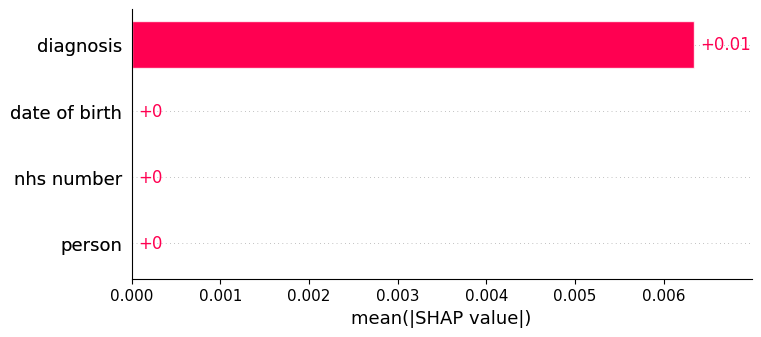

In [24]:
# Plot the mean shap values - global explanation
explainer.plot_global_explanation(exp_obj)

In [25]:
# Plot the local shap values for a particular record
explainer.plot_local_explanation(exp_obj, 49)

49 is not in list or record is baseline record.
